In [1]:
import os
import pyspark 
from pyspark.sql import SparkSession
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.sql.functions import col


In [2]:
from dotenv import load_dotenv
load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

In [3]:
spark = SparkSession.builder \
    .master("local[3]") \
    .appName("Airbnb Listings") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()       


    

In [4]:

# Read data from GCS
df = spark.read.parquet("gs://airbnb-listings-421017-bucket/airbnb_listings.parquet")


#### Analyzing the listings based on room types


<Axes: xlabel='room_type', ylabel='count'>

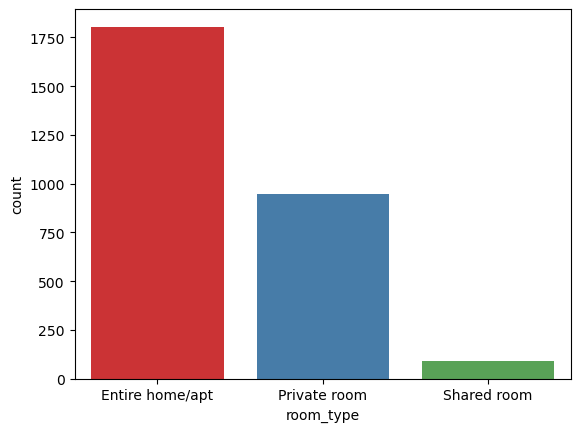

In [5]:
from pyspark.sql.functions import col

# get the number of listings per room type descending

room_type_counts =df.groupBy("room_type").count().orderBy(col("count").desc()).toPandas()
sb.barplot(x = "room_type",y="count" ,  data = room_type_counts, palette="Set1")



#### Analyzing the listings based on the property type.


<Axes: xlabel='property_type', ylabel='count'>

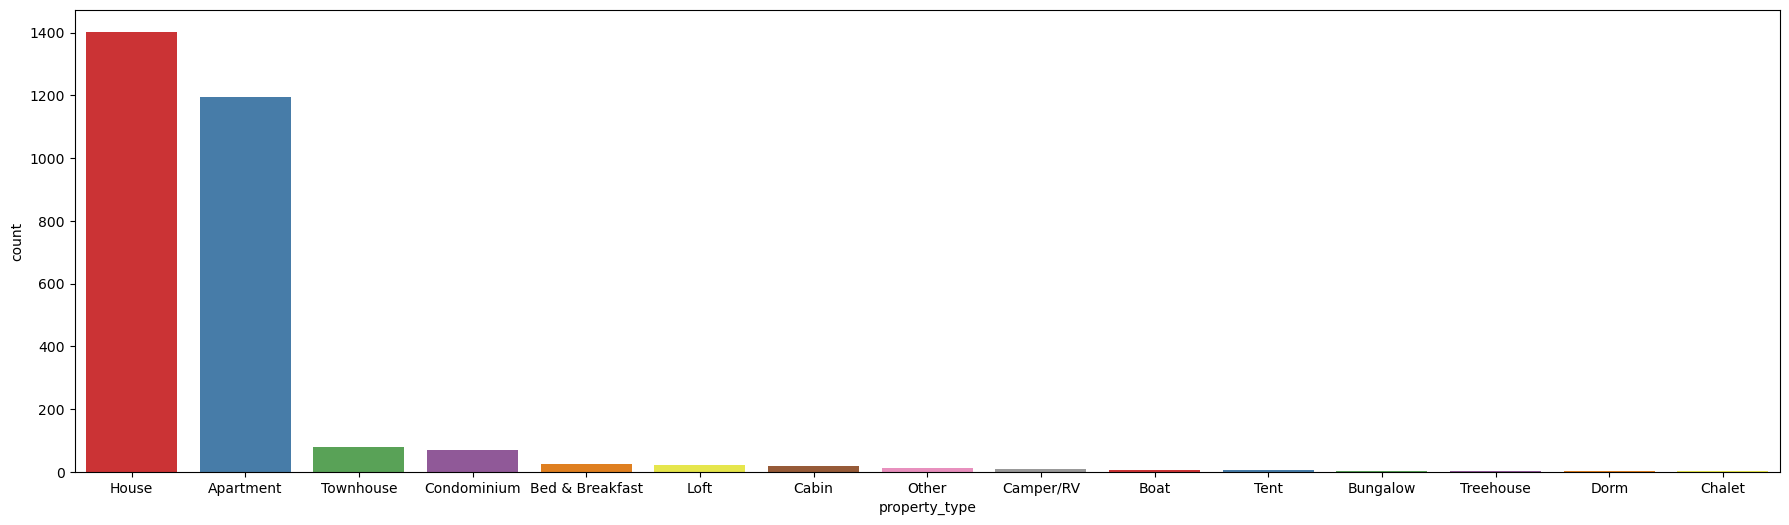

In [6]:

property_type_counts = df.groupBy("property_type").count().orderBy(col("count").desc()).toPandas()
plt.figure(figsize=(22, 6))  # Adjust the width and height as needed
sb.barplot(x = "property_type",y="count" ,  data = property_type_counts, palette="Set1")

#### Analyzing the prices for the different room and property types.


In [ ]:
# get the price group by room_type and property_type
price_group = df.groupBy("room_type","property_type").agg({"price":"avg"}).toPandas()

C:\Users\Mohamed Hussein\AppData\Local\Temp\ipykernel_13580\626276968.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  price_heatmap = price_group.pivot("property_type","room_type","avg(price)")


<Axes: xlabel='room_type', ylabel='property_type'>

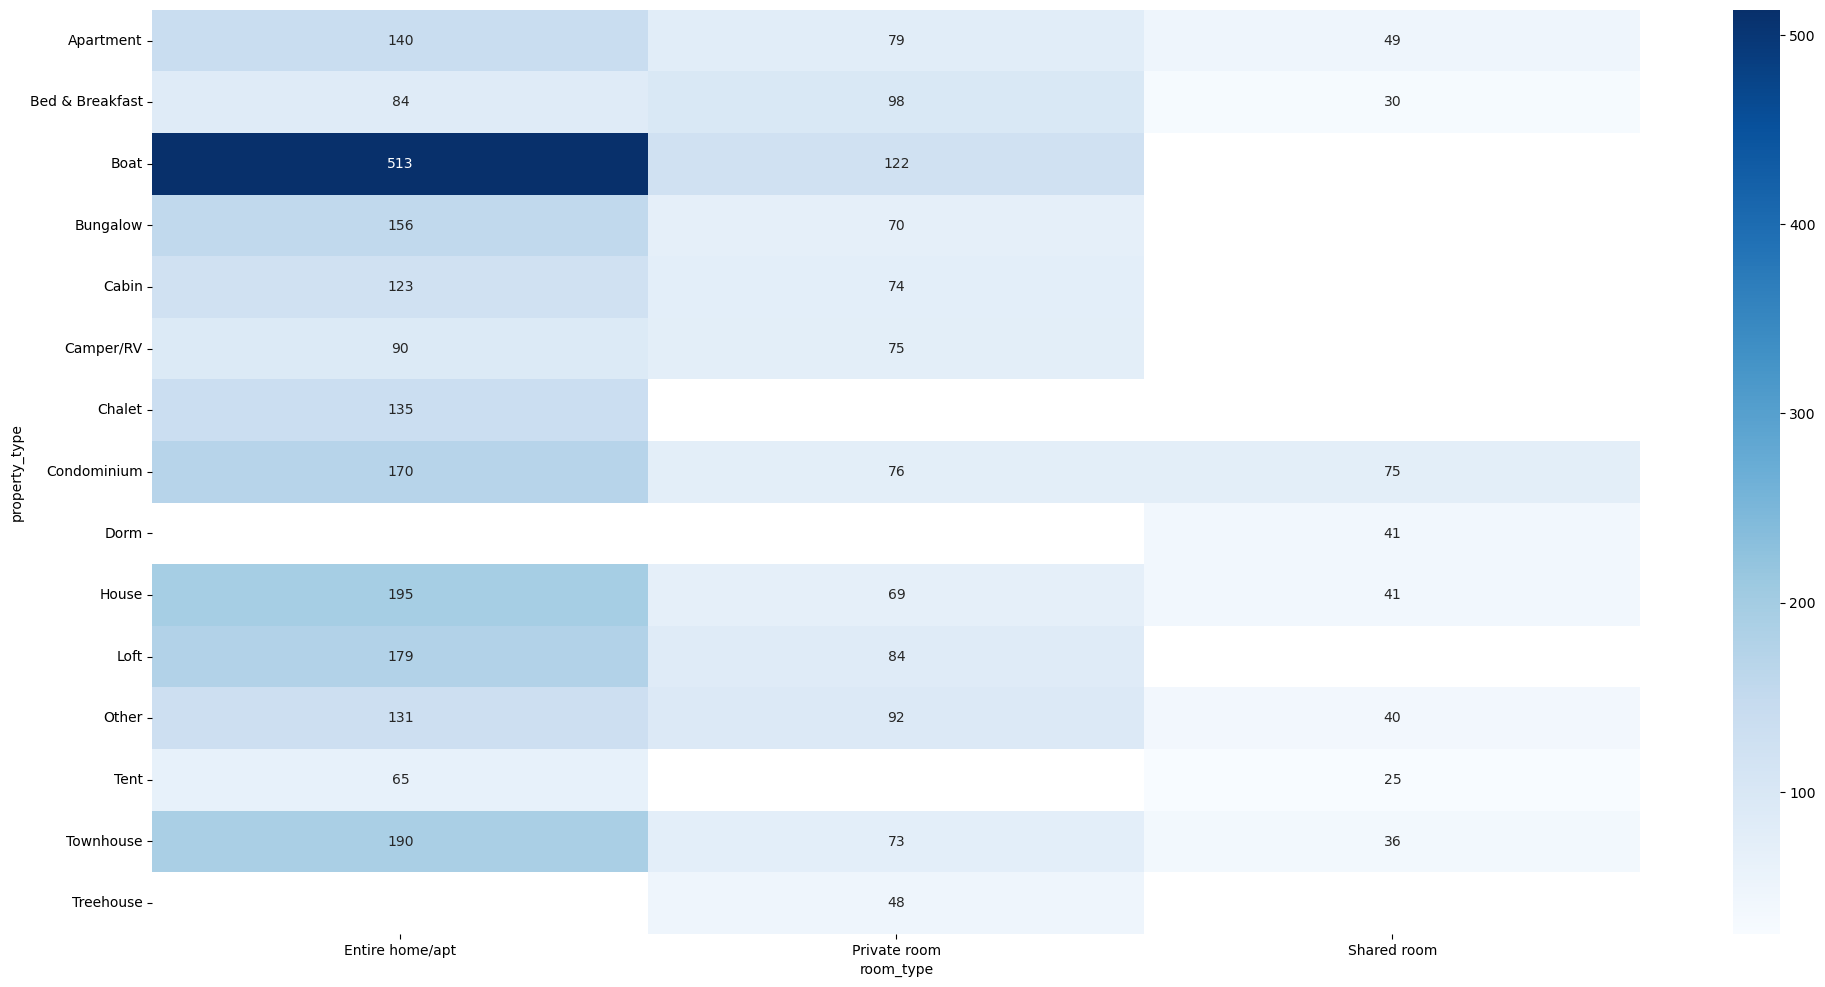

In [8]:
# heat map 
price_heatmap = price_group.pivot("property_type","room_type","avg(price)") 
# print(price_heatmap)
plt.figure(figsize=(24, 12))  # Adjust the width and height as needed
sb.heatmap(price_heatmap, cmap="Blues", annot=True, fmt=".0f")


#### Anaylzing the listings based on the number of bedrooms.


In [9]:

beds_count = df.select('price','bedrooms').toPandas()

In [10]:
print(beds_count)

      price  bedrooms
0      85.0       1.0
1     150.0       1.0
2     975.0       5.0
3     450.0       3.0
4     120.0       1.0
...     ...       ...
2838  154.0       2.0
2839   65.0       1.0
2840   95.0       1.0
2841  359.0       3.0
2842   79.0       1.0

[2843 rows x 2 columns]


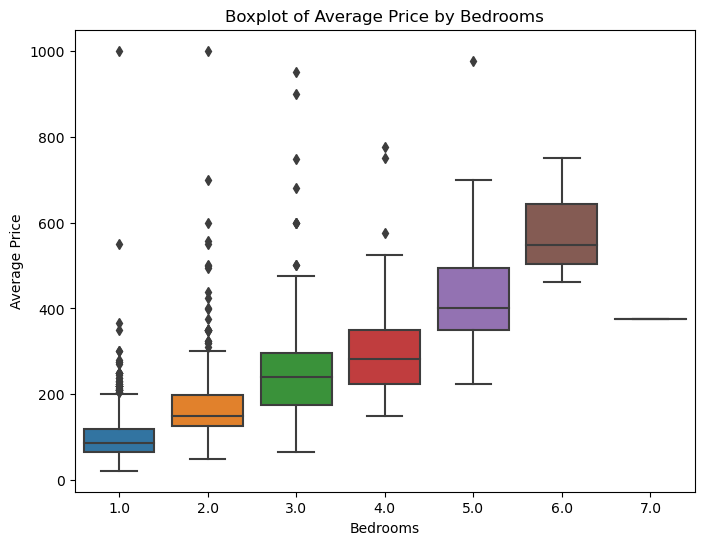

In [11]:
# Create boxplot
plt.figure(figsize=(8, 6))
sb.boxplot(x='bedrooms', y='price', data=beds_count)
plt.title('Boxplot of Average Price by Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Average Price')
plt.show()

#### Analyzing if any particular ammenity results in higher prices.


In [38]:
# return the top 100 amenities by price

top_amenities =df.select('amenities').sort(col("price").desc()).limit(100)

In [ ]:
from pyspark.sql.functions import split, explode, regexp_extract, regexp_replace

regex_pattern = r'[a-zA-Z]+' # extract only the words
# remove the special characters
top_amenities = top_amenities.withColumn("amenities", regexp_replace(col("amenities"), '[{}"\\s]+', ' '))

top_amenities = top_amenities.withColumn('amenities', explode(split(top_amenities['amenities'], ',')))

# transform the data to lowercase and then return it as a list 



In [45]:
# top_amenities.distinct().show()
# import rdd

ammenities_list = top_amenities.select('amenities').rdd.flatMap(lambda x: x).collect() 

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 19.0 failed 1 times, most recent failure: Lost task 0.0 in stage 19.0 (TID 19) (DESKTOP-S4IOVMC executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:492)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:153)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1107)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:492)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:153)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1107)
	... 19 more
